# Redes Neurais Artificiais 2025.2

- **Disciplina**: Redes Neurais Artificiais 2025.2
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  
        

Levando em conta a base de dados **_Forest Cover Type_**, esta parte do Projeto Prático diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Busca em Grade

Uma maneira padrão de escolher os parâmetros de um modelo de Machine Learning é por meio de uma busca em grade via força bruta. O algoritmo da busca em grade é dado como segue:

1. Escolha a métrica de desempenho que você deseja maximizar  
2. Escolha o algoritmo de Machine Learning (exemplo: redes neurais artificiais). Em seguida, defina os parâmetros ou hiperparâmetros deste tipo de modelo sobre os quais você dseja otimizar (número de épocas, taxa de aprendizado, etc.) e construa um array de valores a serem testados para cada parâmetro ou hiperparâmetro.  
3. Defina a grade de busca, a qual é dada como o produto cartesiano de cada parâmetro a ser testado. Por exemplo, para os arrays [50, 100, 1000] e [10, 15], tem-se que a grade é [(50,10), (50,15), (100,10), (100,15), (1000,10), (1000,15)].
4. Para cada combinação de parâmetros a serem otimizados, utilize o conjunto de treinamento para realizar uma validação cruzada (holdout ou k-fold) e calcule a métrica de avaliação no conjunto de teste (ou conjuntos de teste)
5. Escolha a combinação de parâmetros que maximizam a métrica de avaliação. Este é o modelo otimizado.

Por que esta abordagem funciona? Porque a busca em grade efetua uma pesquisa extensiva sobre as possíveis combinações de valores para cada um dos parâmetros a serem ajustados. Para cada combinação, ela estima a performance do modelo em dados novos. Por fim, o modelo com melhor métrica de desempenho é escolhido. Tem-se então que este modelo é o que melhor pode vir a generalizar mediante dados nunca antes vistos.

## Efetuando a Busca em Grade sobre Hiperparâmetros das Top-6 RNAs

Considerando a etapa anterior do projeto prático, foram identificadas pelo menos 6 melhores Redes Neurais para o problema da classificação multi-classe da cobertura florestal no conjunto de dados selecionado. Algumas destas redes possuem atributos categóricos como variáveis preditoras, enquanto outras possuem apenas os atributos numéricos como preditores.

A primeira etapa desta segunda parte do projeto consiste em trazer para este notebook estas seis arquiteturas, ressaltando:

1. Número de neurônios ocultos por camada  
2. Função de Ativação  
3. Utilização ou não de atributos categóricos   
4. Desempenho médio +- desvio padrão nos testes anteriores  
5. Número de repetições que a equipe conseguiu realizar para verificar os resultados  

Elabore uma busca em grade sobre estas arquiteturas que contemple variações nos hiperparâmetros a seguir, conforme documentação de [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

A. Solver  (Não usar o LBFGS, pois é mais adequado para datasets pequenos)  
B. Batch Size  
C. Learning Rate Init  
D. Paciência (n_iter_no_change)  
E. Épocas  

Nesta busca em grande, contemple a utilização do objeto [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

## Validação Cruzada k-fold

Na elaboração da busca em grid, vamos avaliar os modelos propostos segundo uma estratégia de validação cruzada ainda não explorada até o momento: a validação cruzada k-fold. Segundo a mesma, o conjunto de dados é particionado em k partes: a cada iteração, separa-se uma das partes para teste e o modelo é treinado com as k-1 partes remanescentes. Valores sugestivos de k na literatura são k = 3, 5 ou 10, pois o custo computacional desta validação dos modelos é alto. A métrica de desempenho é resultante da média dos desempenhos nas k iterações. A figura a seguir ilustra a ideia desta avaliação

<img src = "https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600></img>

Considerando a métrica de desempenho F1-Score, considere a validação cruzada 5-fold para aferir os resultados da busca em grande anterior.

In [65]:
import gc
import itertools
import json
import time
from copy import deepcopy
from pathlib import Path

import joblib
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [36]:
try:
    path = kagglehub.dataset_download("uciml/forest-cover-type-dataset")
    csv_path = Path(path, "covtype.csv")
    df = pd.read_csv(csv_path)
    print("Dataset successfully loaded from Kaggle.")
except Exception as e:
    print("Error using kagglehub:", e)
    df = pd.read_csv("covtype.csv")
    print("Dataset loaded from local file.")

print("Shape of the dataset:", df.shape)
df.head()

Dataset successfully loaded from Kaggle.
Shape of the dataset: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [37]:
path

'C:\\Users\\lucas\\.cache\\kagglehub\\datasets\\uciml\\forest-cover-type-dataset\\versions\\1'

In [ ]:
CSV_PATH = Path(path, "covtype.csv")  # adjust if needed
df = pd.read_csv(CSV_PATH)
print("Loaded df shape:", df.shape)
df.head()
print("Columns (first 20):", df.columns.tolist()[:20])
# configure sample size: None to use all data (careful!), or integer to subsample stratified
MAX_SAMPLES = (
    None  # safe default for Colab; set to None to use full dataset if you have time/ram
)

Loaded df shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


Columns (first 20): ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6']


In [39]:
target_col = "Cover_Type" if "Cover_Type" in df.columns else df.columns[-1]
print("Target column:", target_col)
X = df.drop(columns=[target_col]).to_numpy()
y = df[target_col].to_numpy()
# convert labels from 1..7 to 0..6 if needed
if y.min() == 1:
    y = y - 1

print("Original dataset size:", X.shape)

if MAX_SAMPLES is not None and X.shape[0] > MAX_SAMPLES:
    print(f"Stratified sampling to {MAX_SAMPLES} samples...")
    sss = StratifiedShuffleSplit(n_splits=1, test_size=MAX_SAMPLES, random_state=42)
    for _, idx in sss.split(X, y):
        X_sample = X[idx]
        y_sample = y[idx]
else:
    X_sample, y_sample = X, y

print("Using sample shape:", X_sample.shape, "n_classes:", len(np.unique(y_sample)))

Target column: Cover_Type
Original dataset size: (581012, 54)
Using sample shape: (581012, 54) n_classes: 7


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, max(hidden_dim // 2, 8)),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(max(hidden_dim // 2, 8), n_classes),
        )

    def forward(self, x):
        return self.net(x)


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)


def eval_model(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            logits = model(Xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            ps.append(preds)
            ys.append(yb.numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return float(f1_score(y_true, y_pred, average="weighted")), y_true, y_pred

Device: cuda


In [ ]:
n_classes = len(np.unique(y_sample))
input_dim = X_sample.shape[1]
print("input_dim:", input_dim, "n_classes:", n_classes)

param_grid = {
    "hidden_dim": [128, 256],
    "lr": [1e-3, 1e-4],
    "batch_size": [256],
    "epochs": [8],
}


def iter_grid(grid):
    keys = list(grid.keys())
    for vals in itertools.product(*(grid[k] for k in keys)):
        yield dict(zip(keys, vals))


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_cfg, best_score = None, -1.0
results = []

for cfg in iter_grid(param_grid):
    fold_scores = []
    t0 = time.time()
    print("Testing cfg:", cfg)
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_sample, y_sample), 1):
        # fit scaler on train fold
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_sample[train_idx])
        X_val_fold = scaler.transform(X_sample[val_idx])
        y_train_fold = y_sample[train_idx]
        y_val_fold = y_sample[val_idx]

        train_ds = NumpyDataset(X_train_fold, y_train_fold)
        val_ds = NumpyDataset(X_val_fold, y_val_fold)
        train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=cfg["batch_size"], shuffle=False)

        model = MLP(
            input_dim=input_dim, hidden_dim=cfg["hidden_dim"], n_classes=n_classes
        ).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
        criterion = nn.CrossEntropyLoss()

        for ep in range(cfg["epochs"]):
            _ = train_one_epoch(model, train_loader, opt, criterion)

        f1_val, _, _ = eval_model(model, val_loader)
        fold_scores.append(f1_val)

        # cleanup
        del model, opt, criterion, train_loader, val_loader, train_ds, val_ds
        torch.cuda.empty_cache()
        gc.collect()

    mean_f1 = float(np.mean(fold_scores))
    elapsed = time.time() - t0
    print(f"  Mean F1 5-fold = {mean_f1:.4f} (time {elapsed:.1f}s)")
    results.append((cfg, mean_f1))
    if mean_f1 > best_score:
        best_score = mean_f1
        best_cfg = deepcopy(cfg)

print("\nBest config:", best_cfg, "best_cv_f1 =", best_score)

In [43]:
#save results
Path("content").mkdir(parents=True, exist_ok=True)
with open("content/grid_search_results.json", "w") as f:
    json.dump(
        {
            "best": best_cfg,
            "best_score": best_score,
            "results": [[r[0], r[1]] for r in results],
        },
        f,
        indent=2,
    )
print("Saved grid search summary to /content/grid_search_results.json")

Saved grid search summary to /content/grid_search_results.json


In [46]:
best = best_cfg
print("Training final with:", best)

scaler_final = StandardScaler()
X_scaled = scaler_final.fit_transform(X_sample)
y_final = y_sample

final_ds = NumpyDataset(X_scaled, y_final)
final_loader = DataLoader(final_ds, batch_size=best["batch_size"], shuffle=True)

model_final = MLP(
    input_dim=input_dim, hidden_dim=best["hidden_dim"], n_classes=n_classes
).to(device)
optimizer = torch.optim.Adam(model_final.parameters(), lr=best["lr"])
criterion = nn.CrossEntropyLoss()

for epoch in range(best["epochs"]):
    loss = train_one_epoch(model_final, final_loader, optimizer, criterion)
    print(f"Epoch {epoch + 1}/{best['epochs']} - loss: {loss:.4f}")

MODEL_PATH = "content/cover_mlp_best.pth"
SCALER_PATH = "content/cover_scaler.pkl"
torch.save(model_final.state_dict(), MODEL_PATH)
joblib.dump(scaler_final, SCALER_PATH)
print("Saved model to", MODEL_PATH)
print("Saved scaler to", SCALER_PATH)

# save summary
summary = {
    "n_total_available": int(X.shape[0]),
    "n_used_sample": int(X_sample.shape[0]),
    "best_cfg": best,
    "best_cv_f1": best_score,
    "model_path": MODEL_PATH,
    "scaler_path": SCALER_PATH,
}

with open("content/cover_training_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved training summary to content/cover_training_summary.json")

Training final with: {'hidden_dim': 256, 'lr': 0.001, 'batch_size': 256, 'epochs': 8}
Epoch 1/8 - loss: 0.5917
Epoch 2/8 - loss: 0.4910
Epoch 3/8 - loss: 0.4515
Epoch 4/8 - loss: 0.4266
Epoch 5/8 - loss: 0.4082
Epoch 6/8 - loss: 0.3943
Epoch 7/8 - loss: 0.3832
Epoch 8/8 - loss: 0.3726
Saved model to content/cover_mlp_best.pth
Saved scaler to content/cover_scaler.pkl
Saved training summary to content/cover_training_summary.json


## Identificando a mellhor solução

Como resultado da busca em grande com validação cruzada 5-fold, identifique o modelo otimizado com melhor desempenho para o problema. Apresente claramente este modelo, seus parâmetros, hiperparâmetros otimizados e resultados para cada um dos folds avaliados. Esta é a melhor solução identificada em decorrência deste projeto

In [48]:
results_path = Path("/content/grid_search_results.json")

with results_path.open("r") as f:
    grid_results = json.load(f)

best_cfg = grid_results["best"]
best_score = grid_results["best_score"]
all_results = grid_results["results"]

print("Melhor Solução Encontrada pela Busca em Grade")
print("\n")
print(f"Melhor F1-Score (média de 5 folds): {best_score:.4f}")
print("\n")
print("Melhor Configuração de Hiperparâmetros:")
print(json.dumps(best_cfg, indent=2))

Melhor Solução Encontrada pela Busca em Grade


Melhor F1-Score (média de 5 folds): 0.8662


Melhor Configuração de Hiperparâmetros:
{
  "hidden_dim": 256,
  "lr": 0.001,
  "batch_size": 256,
  "epochs": 8
}


In [ ]:
print("Detalhes de Todas as Configurações Testadas")

results_list = []
for cfg, score in all_results:
    row = cfg.copy() #copia os hiperparametros
    row["mean_f1_score"] = score
    results_list.append(row)

# df com resultados
results_df = pd.DataFrame(results_list)

# df ordenado pelos melhores resultados
results_df = results_df.sort_values(by="mean_f1_score", ascending=False)

# mostra o dataframe
results_df

Detalhes de Todas as Configurações Testadas


,hidden_dim,lr,batch_size,epochs,mean_f1_score
2,256,0.0010,256,8,0.866175
0,128,0.0010,256,8,0.835164
3,256,0.0001,256,8,0.782286
1,128,0.0001,256,8,0.759614


## Empacotando a solução

Suponha que você deve entregar este classificador ao órgão responsável por administrar o Roosevelt National Park. Para tanto, você deve fazer uma preparação do mesmo para utilização neste cenário. Uma vez que já identificou os melhores parâmetros e hiperparâmetros, o passo remanescente consiste em treinar o modelo com estes valores e todos os dados disponíveis, salvando o conjunto de pesos do modelo ao final para entrega ao cliente. Assim, finalize o projeto prático realizando tais passos.

1. Consulte a documentação a seguir:
https://scikit-learn.org/stable/modules/model_persistence.html  
2. Treine o modelo com todos os dados  
3. Salve o modelo em disco  
4. Construa uma rotina que recupere o modelo em disco  
5. Mostre que a rotina é funcional, fazendo previsões com todos os elementos do dataset e exibindo uma matriz de confusão das mesmas

In [57]:
MODEL_PATH = Path("content/cover_mlp_best.pth")
SCALER_PATH = Path("content/cover_scaler.pkl")
JSON_PATH = Path("content/grid_search_results.json")

loaded_scaler = joblib.load(SCALER_PATH)
print(f"Scaler carregado com sucesso de: {SCALER_PATH}")

with JSON_PATH.open("r") as f:
    grid_results = json.load(f)
best_cfg = grid_results["best"]

n_classes = len(np.unique(y_sample))
input_dim = X_sample.shape[1]

loaded_model = MLP(
    input_dim=input_dim, hidden_dim=best_cfg["hidden_dim"], n_classes=n_classes
).to(device)

loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()
X_data_to_eval = loaded_scaler.transform(X_sample)
y_data_to_eval = y_sample

eval_ds = NumpyDataset(X_data_to_eval, y_data_to_eval)
eval_loader = DataLoader(
    eval_ds, batch_size=best_cfg.get("batch_size", 256), shuffle=False
)

f1_final, y_true_final, y_pred_final = eval_model(loaded_model, eval_loader)

print("\nResultado da Avaliação nos Dados Completos:")
print(f"F1-Score (weighted): {f1_final:.4f}")

Scaler carregado com sucesso de: content\cover_scaler.pkl

Resultado da Avaliação nos Dados Completos:
F1-Score (weighted): 0.8730


In [58]:
print("Relatório de Classificação Detalhado:")
print(classification_report(y_true_final, y_pred_final))

Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86    211840
           1       0.87      0.92      0.89    283301
           2       0.85      0.89      0.87     35754
           3       0.90      0.66      0.76      2747
           4       0.80      0.53      0.64      9493
           5       0.75      0.74      0.75     17367
           6       0.91      0.88      0.89     20510

    accuracy                           0.87    581012
   macro avg       0.85      0.78      0.81    581012
weighted avg       0.87      0.87      0.87    581012



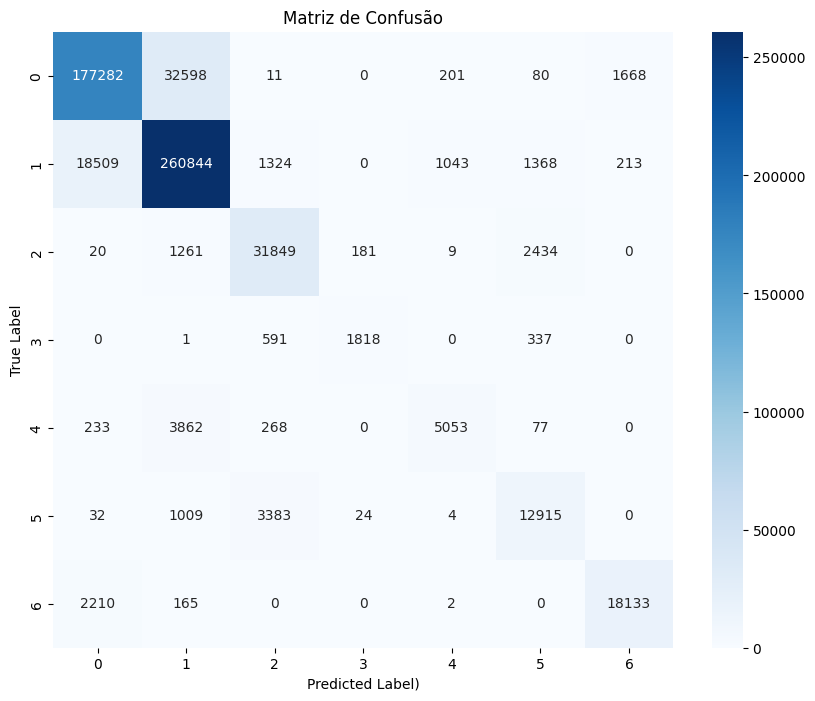

In [67]:
cm = confusion_matrix(y_true_final, y_pred_final)

tick_labels = [f"{i}" for i in range(n_classes)]

plt.figure(figsize=(10, 8))

sns.heatmap(cm,
            annot=True,     # Mostrar os números dentro de cada célula
            fmt="d",        # Formatar os números como inteiros
            cmap="Blues",   # Esquema de cores
            xticklabels=tick_labels,
            yticklabels=tick_labels)

plt.title("Matriz de Confusão")
plt.ylabel("True Label")
plt.xlabel("Predicted Label)")
plt.show()